152.0
#of processed events:  1000
Plots for channel  0


<Figure size 864x288 with 0 Axes>

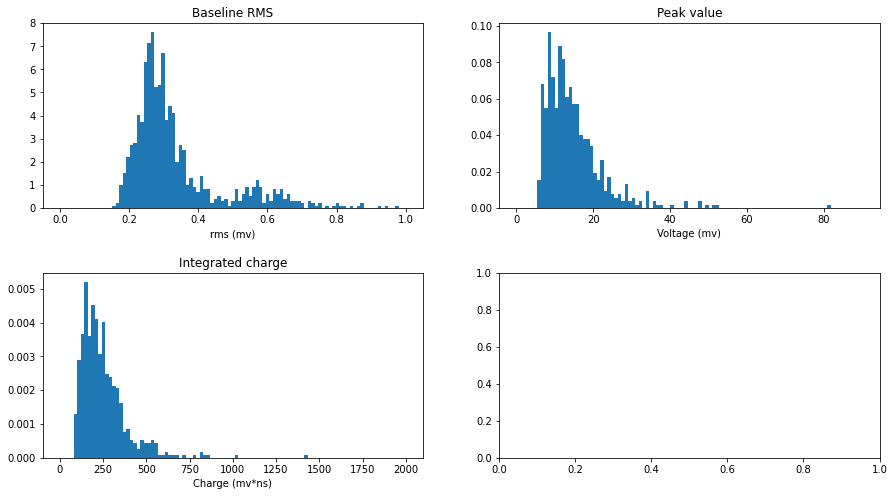

Plots for channel  1


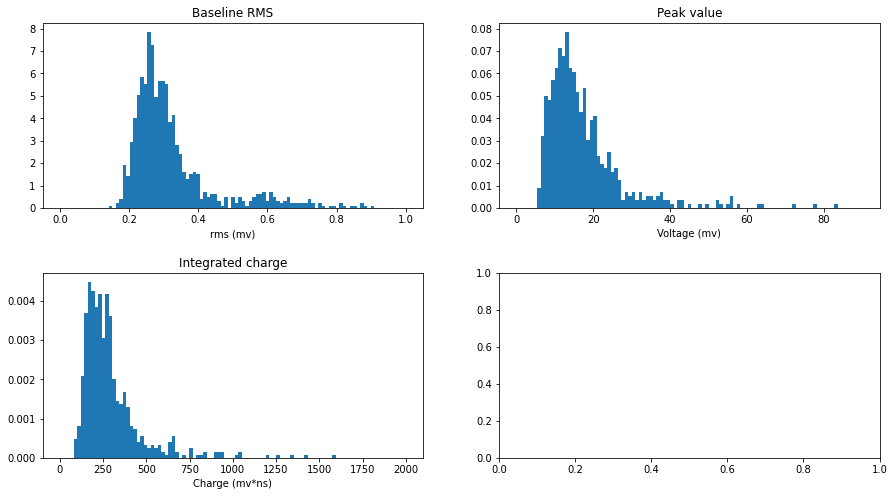

Plots for channel  2


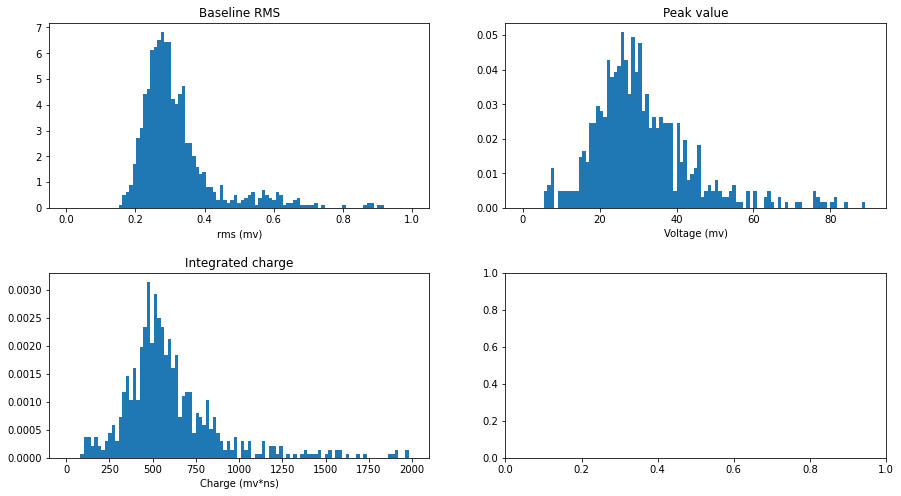

Plots for channel  3


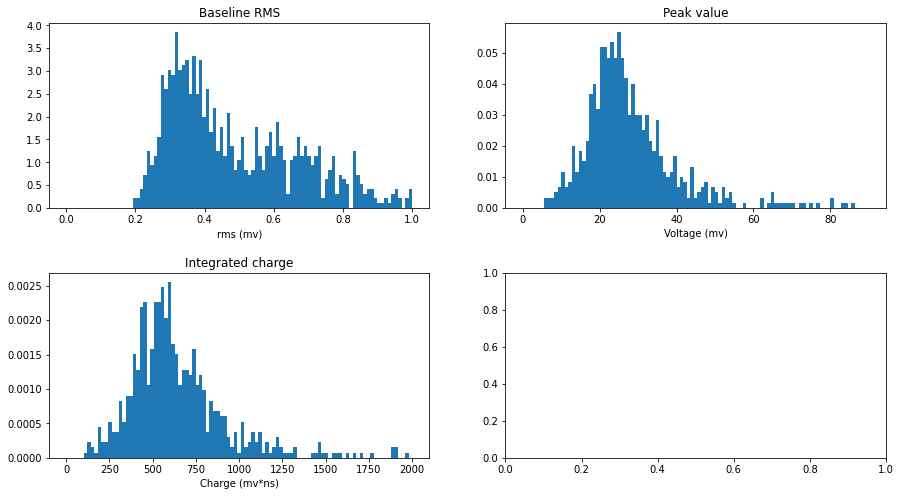

In [3]:
#import sys
import numpy as np
from scipy import signal as ss
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#args=sys.argv

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N])/ float(N)

def peakSearch_simple(wf,height,width,start,nwindow):
    nabove=0
    peak=[]
    for i in range(start,start+nwindow):
        if wf[i]>height: nabove=nabove+1
        else:
            if nabove>=width:
                maximum=-1
                peakidx=-1
                for j in range(i,i-nabove,-1):
                    if maximum<wf[j]:
                        maximum=wf[j]
                        peakidx=j
                peak.append(peakidx)
            nabove=0
    return np.array(peak,dtype=int)

def peakSearch_ss(wf,height,width):
    peaks, _ = ss.find_peaks(wf,height,width)
    return peaks

#fname='test_three_counters_one_is_dead_thr8mV_top_and_bottom_1_0.npy'

startTime=190
print(startTime*0.8)
windowSize=int(100./0.8)
nsub=10
pedRegion=int(50./0.8)
numAve=5
startPoint = int(startTime/0.8)
startPoint2= startPoint + numAve

flist=[]
#flist.append('/home/comet/work/pico/data/test_three_counters_one_is_dead_thr8mV_top_and_bottom_1_0.npy')
#flist.append('/home/comet/work/pico/data/test_three_counters_one_is_dead_thr8mV_top_and_bottom_1_1.npy')
#flist.append('/home/comet/work/pico/data/test_three_counters_one_is_dead_thr8mV_top_and_bottom_1_2.npy')
#flist.append('/home/comet/work/pico/data/test_three_counters_one_is_dead_thr8mV_top_and_bottom_1_3.npy')
#flist.append('/home/comet/work/pico/data/test_three_counters_one_is_dead_thr8mV_top_and_bottom_1_4.npy')
#flist.append('/home/comet/work/pico/data/test_three_counters_one_is_dead_thr8mV_top_and_bottom_1_5.npy')
#flist.append('/home/comet/work/pico/data/test_three_counters_one_is_dead_thr8mV_top_and_bottom_1_6.npy')
#flist.append('/home/comet/work/pico/data/test_three_counters_one_is_dead_thr8mV_top_and_bottom_1_7.npy')
#flist.append('/home/comet/work/pico/data/test_three_counters_one_is_dead_thr8mV_top_and_bottom_1_8.npy')
#flist.append('/home/comet/work/pico/data/test_three_counters_one_is_dead_thr8mV_top_and_bottom_1_9.npy')
flist.append('/home/comet/work/pico/data/FourCounters_16_07_20_Thresh6mV_run1_0.npy')

#if fname.find(".txt")<0:
#    for f in range(nsub):
#        flist.append(fname+str(f)+'.npy')
#else:
#    f=open(fname,'r')
#    line=f.readline()
#    while (line!=''):
#        line=f.readline()
#        if line.rstrip()=='':break
#        flist.append(line.rstrip())
#    f.close()
if nsub>len(flist):
    nsub=len(flist)

plt.ion()
plt.figure(figsize=(12,4))
base=[np.array([]),np.array([]),np.array([]),np.array([])]
wfrms=[np.array([]),np.array([]),np.array([]),np.array([])]
vmax=[np.array([]),np.array([]),np.array([]),np.array([])]
charge=[np.array([]),np.array([]),np.array([]),np.array([])]
polarity=-1.0
timeIntervalns=0.8
startPeakSearch=int(190./0.8)
thr=4

nev=0
for f in range(nsub):
    ifile=open(flist[f],"rb")
    data=np.load(ifile,allow_pickle=True)
    ndata=len(data)
    arrays=data[ndata-1]
    nwf=len(arrays)
    #print(nwf)
    #print(len(arrays))
    for i in range(nwf):
        ch=(i%4)
        #if(ch!=1):continue
        arr=arrays[i]
        avwf = running_mean(arr[:],numAve)
        #sos = ss.butter(2,[1e6,400e6],btype='bandpass',analog=False,fs=2.5e9,output='sos')
        #avwf = ss.sosfilt(sos,arr)
        #print(avwf[:pedRegion].std())
        if avwf[:pedRegion].std() > thr: continue
        #baseline =avwf[:windowSize].mean()
        #chargeTmp=(polarity*(avwf[startPoint:startPoint+windowSize].sum()-baseline*windowSize))
        #wfrms = np.append(wfrms, avwf[:windowSize].std())     # standard deviation
        baseline =avwf[:pedRegion].mean()
        avwf = polarity*(avwf-baseline)
        #peaks = peakSearch_ss(avwf[startPeakSearch:],0.7,5)
        peaks = peakSearch_simple(avwf,5,10,startPoint2,windowSize)
        chargeTmp=avwf[startPoint:startPoint+windowSize].sum()
        base[ch]  = np.append(base[ch], baseline)                    # mean value of the baseline
        wfrms[ch] = np.append(wfrms[ch], avwf[:pedRegion].std())     # standard deviation
        #peaks=peaks+startPeakSearch
        if len(peaks)>0:
            vmax[ch]  = np.append(vmax[ch],avwf[peaks[0]])
            charge[ch]= np.append(charge[ch],(avwf[peaks[0]-8:peaks[0]+52].sum())*timeIntervalns)   # integrated charge
            prePeak=peaks[0]
        timeX = np.linspace(0, float(len(arr))*timeIntervalns, len(arr))
        #print(arr)
        if(ch==0): nev = nev+1
        if(ch!=1 or i%200!=0):continue
        plt.figure(figsize=(12,4))
        plt.plot(timeX,polarity*arr)
        plt.plot(timeX[numAve-1:],avwf)
        plt.plot(timeX[peaks+numAve],avwf[peaks],"x")
        plt.ylim(-4,80)
        plt.ylabel('voltage [mV]')
        plt.xlabel('time [ns]')
        plt.draw()
        plt.pause(0.1)
        plt.clf()
    
    ifile.close

print('#of processed events: ',nev)
nbins=100

def plot(ch):
    print('Plots for channel ',ch)
    fig = plt.figure(figsize=(15,8))
    gs  = gridspec.GridSpec(2,2,hspace=0.35)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,0])
    ax4 = plt.subplot(gs[1,1])

    xbins=np.linspace(0,1,nbins)
    ax1.hist(wfrms[ch],bins=xbins,density=True)
    ax1.set_title('Baseline RMS')
    ax1.set_xlabel('rms (mv)')

    xbins=np.linspace(0,90,nbins)
    ax2.hist(vmax[ch],bins=xbins,density=True)
    ax2.set_title('Peak value')
    ax2.set_xlabel('Voltage (mv)')

    xbins=np.linspace(0,2000,nbins)
    ax3.hist(charge[ch],bins=xbins,density=True)
    ax3.set_title('Integrated charge')
    ax3.set_xlabel('Charge (mv*ns)')
    plt.show()

plot(0)
plot(1)
plot(2)
plot(3)

#fig.savefig('/home/comet/Desktop/figC.png')

#plt.clear()